# Project - Credit card fraud detection 

Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [9]:
## Importing all the necessary libraries
## To suppress warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)   ## set random seed
import pandas as pd
import chardet
import os
import pickle
from collections import Counter

# For plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

## time and datetime
import datetime
import time


## Pandas DataFrame display options
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_seq_items', None) #For printing a long-sequence


In [10]:
## Read the dataset: 'creditcard.csv' 
df = pd.read_csv("C:/Users/Sandeep/Desktop/fALL 22 SUBJECTS/Data mining/Project/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [12]:
## Check number of records and feature columns (df.shape)
df.shape

(284807, 31)

In [13]:
## Columns in the DataFrame
df= df.rename(columns=lambda x: x.strip())   ##Removing whitespaces in column names (if any)
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [14]:
## Observing different feature types present in the data (dataframe summary)
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [15]:
# Statistics summary
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [16]:
np.sum(df.isnull())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [30]:
# We have 492 fraud transactions and 284,315 non-fraud transactions which can be understood from the .value_counts() functions on Class column i.e fraud or not fraud column.

classes=df['Class'].value_counts() 
print(classes)
normal_share=classes[0]/df['Class'].count()*100
print(normal_share)
fraud_share=classes[1]/df['Class'].count()*100
print(fraud_share)

0    284315
1       492
Name: Class, dtype: int64
99.82725143693798
0.1727485630620034


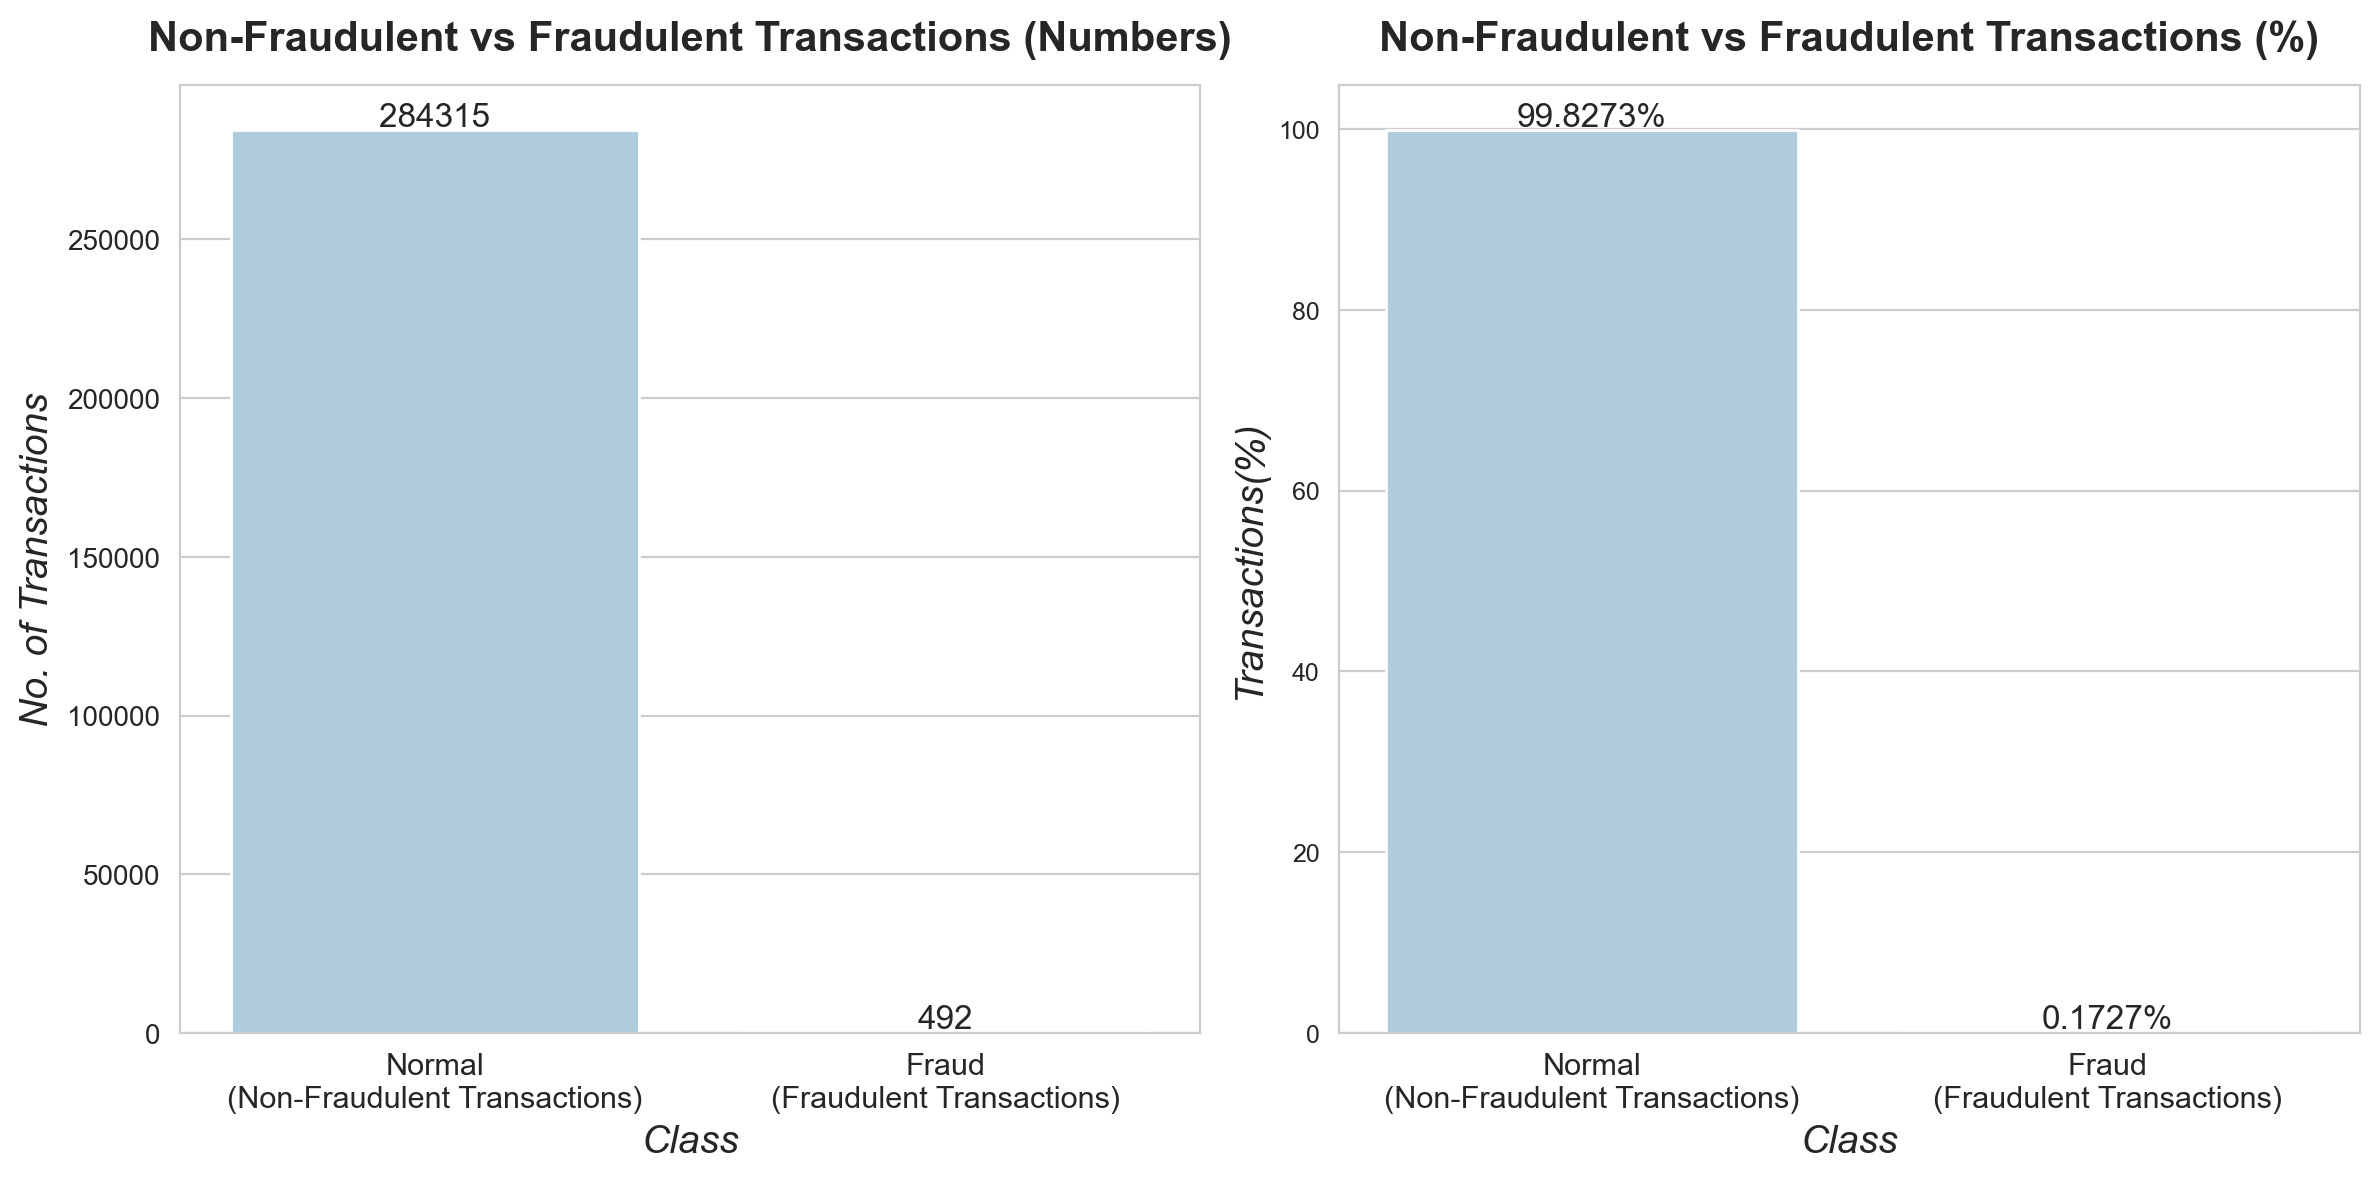

In [31]:
# Creating a bar plot for the number and percentage of non-fraudulent transcations vs fraudulent transactions


## Creating a dataframe containing number and percentage of classes
class_data= [["Normal (Non-Fraudulent)", classes[0], normal_share],\
             ["Fraud (Fraudulent)", classes[1], fraud_share]]
df_class= pd.DataFrame(class_data, columns=["Class", "num_transactions", "prcnt_transactions"])


plt.figure(figsize=(12,6), dpi=200)
sns.set_style("whitegrid")


##Subplot_121 (Barplot for Number of non-fraudulent transactions vs fraudulent transactions)
plt.subplot(1,2,1)
ax_1= sns.barplot(data = df_class,x= "Class", y="num_transactions", palette=("Paired"))
ax_1.set_xticklabels(labels=['Normal\n(Non-Fraudulent Transactions)','Fraud\n(Fraudulent Transactions)'], fontsize=11)
plt.title("Non-Fraudulent vs Fraudulent Transactions (Numbers)", fontsize=15, fontweight='bold', y=1.02)
plt.ylabel("No. of Transactions", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=10)

for i in ax_1.patches:
    ax_1.annotate("{0:.0f}".format(i.get_height()), (i.get_x() + i.get_width() / 2.\
                                                 , i.get_height()), ha = 'center'\
        , va = 'top' , xytext = (0, 10), textcoords = 'offset points',rotation=0, fontsize=12)

    
##Subplot_122 (Barplot for Percentage of non-fraudulent transactions vs fraudulent transactions)
plt.subplot(1,2,2)
ax_2= sns.barplot(data = df_class,x= "Class", y="prcnt_transactions", palette=("Paired"))
ax_2.set_xticklabels(labels=['Normal\n(Non-Fraudulent Transactions)','Fraud\n(Fraudulent Transactions)'], fontsize=11)
plt.title("Non-Fraudulent vs Fraudulent Transactions (%)", fontsize=15, fontweight='bold', y=1.02)
plt.ylabel("Transactions(%)", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=9)

for j in ax_2.patches:
    ax_2.annotate("{0:.4f}".format(j.get_height())+"%", (j.get_x() + j.get_width() / 2.\
                                                 , j.get_height()), ha = 'center'\
        , va = 'top' , xytext = (0, 10), textcoords = 'offset points',rotation=0, fontsize=12)

plt.tight_layout()
plt.autoscale()
plt.show()

In [32]:
## Let's find the maximum transaction amount in Fraud Cases (Class Label: 1).
max_trnsctn_fraud= df[df.Class==1]["Amount"].max()
print(f"Maximum fraud transaction amount: €{max_trnsctn_fraud}")

Maximum fraud transaction amount: €2125.87


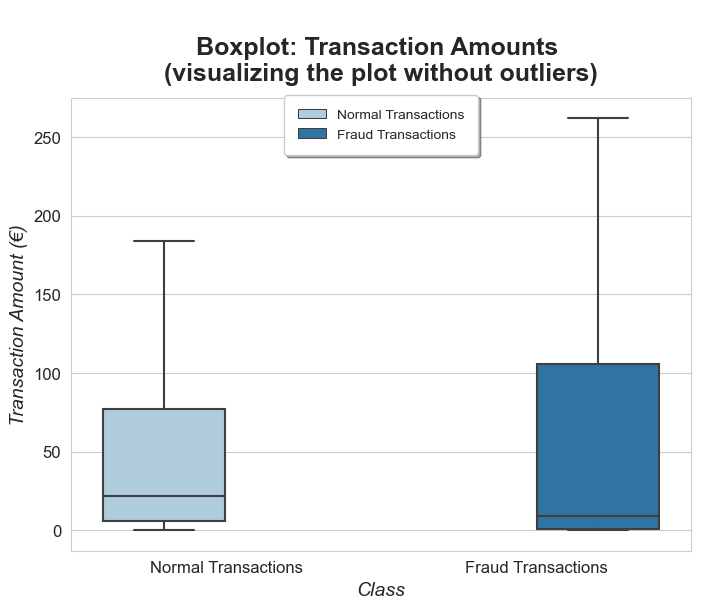

In [33]:
## Visualising the statistics of transaction amounts
plt.figure(figsize=(8,6), dpi=100)
sns.set_style("whitegrid")

 ## Note: Set (showflier=False) to eliminate the effect of outliers in the transaction amounts
ax_31= sns.boxplot(data=df, y="Amount", x="Class", hue="Class",showfliers=False, palette=("Paired")) 
ax_31.set_xticklabels(labels=['Normal Transactions','Fraud Transactions'], fontsize=12)
plt.title(f"\nBoxplot: Transaction Amounts \n(visualizing the plot without outliers)", fontsize=18, fontweight='bold', y=1.02)
plt.ylabel("Transaction Amount (€)", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=12)

#legend
L31= ax_31.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
L31.get_texts()[0].set_text('Normal Transactions')
L31.get_texts()[1].set_text('Fraud Transactions')

plt.show()

In [34]:
df.Time.head()

0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
Name: Time, dtype: float64

In [35]:
df.Time.tail()

284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, dtype: float64

In [36]:
## Using pandas 'to_timedelta' to convert pandas Series from a recognized timedelta format / value into a Timedelta type
Time_Delta= pd.to_timedelta(df.Time, unit='s')
Time_Delta.head()

0   0 days 00:00:00
1   0 days 00:00:00
2   0 days 00:00:01
3   0 days 00:00:01
4   0 days 00:00:02
Name: Time, dtype: timedelta64[ns]

In [37]:
Time_Delta.tail()

284802   1 days 23:59:46
284803   1 days 23:59:47
284804   1 days 23:59:48
284805   1 days 23:59:48
284806   1 days 23:59:52
Name: Time, dtype: timedelta64[ns]

In [38]:
## Extracting the number of days, hours and minutes from 'Time_Delta' variable.
df['Time_Days']= (Time_Delta.dt.components.days).astype(int) ## Number of days
df['Time_Hours']= (Time_Delta.dt.components.hours).astype(int) ## Number of hours
df['Time_Minutes']= (Time_Delta.dt.components.minutes).astype(int) ## Number of minutes
df[['Time', 'Time_Days', 'Time_Hours', 'Time_Minutes']].tail()  ##Checking the tail for verifying successful operations

,Time,Time_Days,Time_Hours,Time_Minutes
284802,172786.0,1,23,59
284803,172787.0,1,23,59
284804,172788.0,1,23,59
284805,172788.0,1,23,59
284806,172792.0,1,23,59


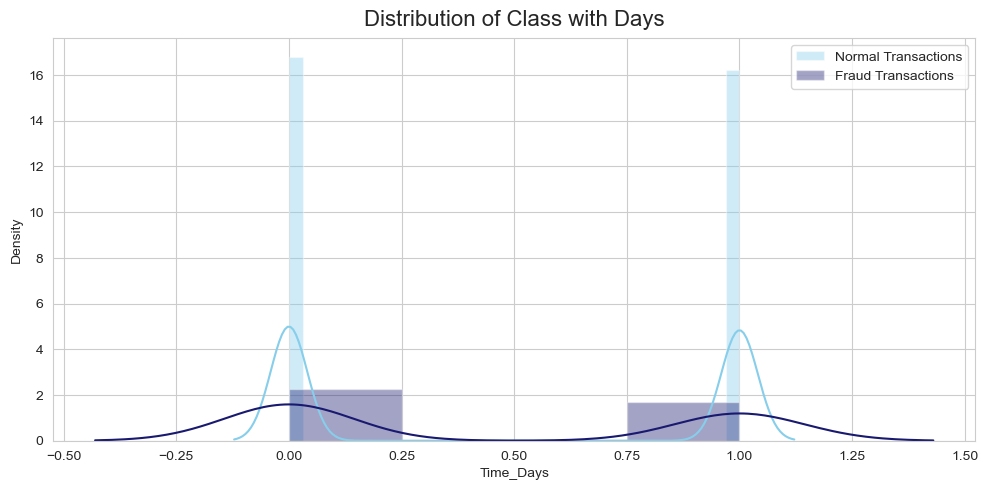

In [39]:
## Analyzing distribution of classes with days

plt.figure(figsize=(10,5), dpi=100)

sns.distplot(df[df.Class == 0]["Time_Days"], label= "Normal Transactions", color='skyblue')
sns.distplot(df[df.Class == 1]["Time_Days"], label= "Fraud Transactions", color= 'midnightblue')

plt.title('Distribution of Class with Days', fontsize=16, y=1.01)
plt.legend()
plt.tight_layout()
plt.show()

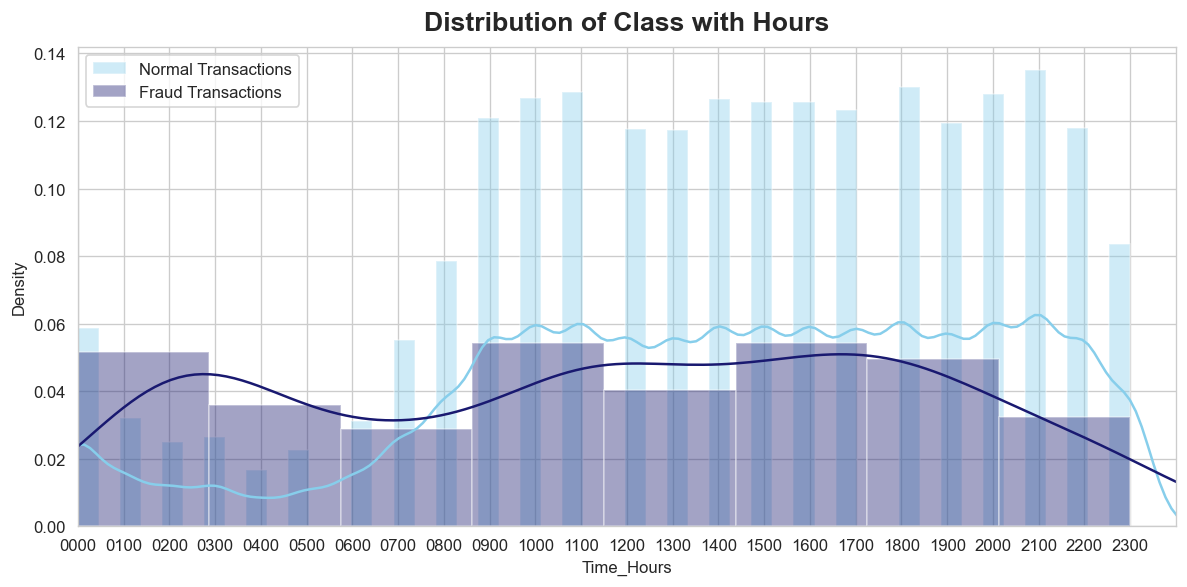

In [40]:
## Analyzing distribution of classes with hours

fig= plt.figure(figsize=(10,5), dpi=120)
ax_4= fig.add_subplot(1,1,1)
sns.set_style("whitegrid")

ax_4= sns.distplot(df[df.Class == 0]["Time_Hours"], label= "Normal Transactions", color='skyblue')  # Distplot for normal transactions
ax_4= sns.distplot(df[df.Class == 1]["Time_Hours"], label= "Fraud Transactions", color= 'midnightblue')  #Distplot for fraud transactions
  
ax_4.set_title('Distribution of Class with Hours', fontsize=16, fontweight='bold', pad=10)
plt.xlim(0,24)                          ## Limitng the x-axis to number of hours in a day
ax_4.set_xticks(np.arange(0,24))

## List Labels
list_a= ['0'+str(i) for i in list(np.arange(0,10))]
list_b= [str(i) for i in list(np.arange(10,24))]
list_a.extend(list_b)
list_hours= [str(j)+"00" for j in list_a]
ax_4.set_xticklabels(list_hours)

plt.legend()
plt.tight_layout()
plt.show()

In [41]:
## Checking the hour at which most frauds occur
num_fraud_hrs= df[df.Class==1]['Time_Hours'].value_counts()
num_fraud_hrs

2     57
11    53
18    33
17    29
15    26
4     23
7     23
14    23
16    22
23    21
19    19
20    18
13    17
12    17
3     17
9     16
21    16
5     11
1     10
8      9
6      9
22     9
10     8
0      6
Name: Time_Hours, dtype: int64

In [42]:
## Check total number of hours (must round to 24)
len(num_fraud_hrs)

24

In [43]:
# Drop unnecessary columns 
drop_columns= ["Time","Time_Days","Time_Hours", "Time_Minutes"]  # (all time variables - original and derived ones)
df.drop(drop_columns, axis=1, inplace= True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


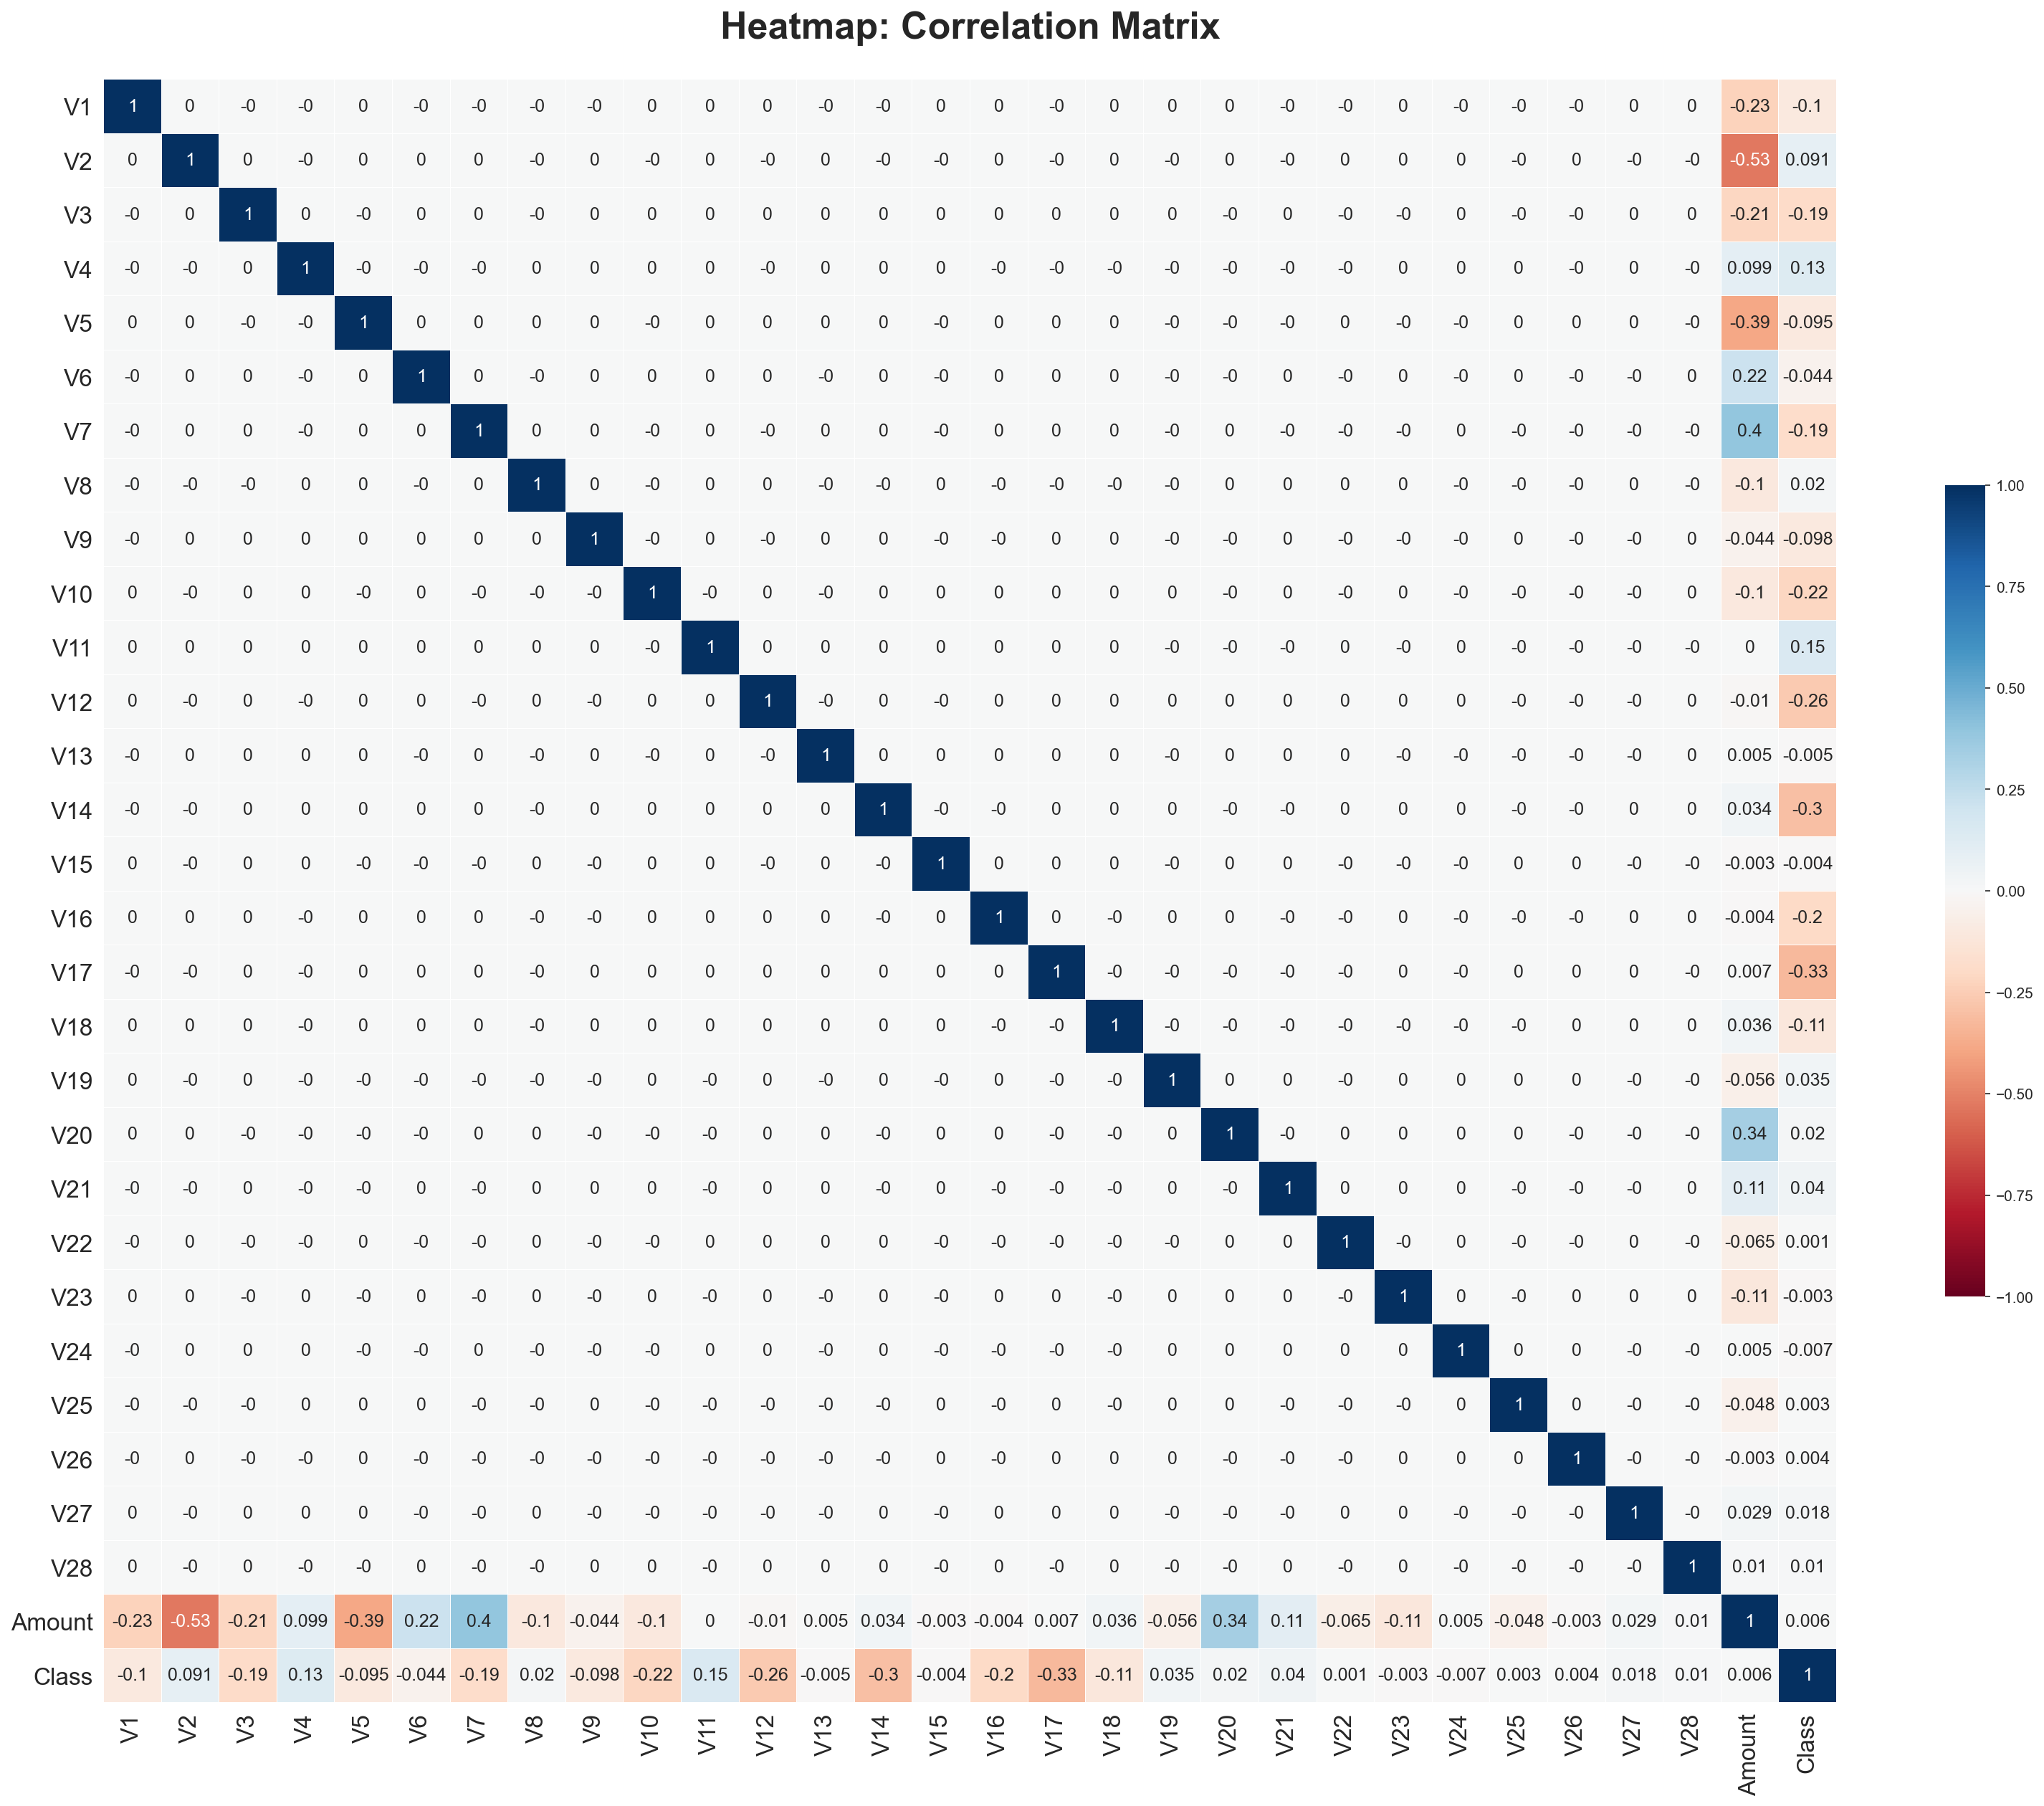

In [44]:
##Let's check the correlation between all the feature variables to see if there is pattern between variables

#Plotting a heatmap to understand the correlation between the independent variables
corr_matrix = df.corr()
corr_matrix_round= round(corr_matrix, 3)
f, ax_corr = plt.subplots(figsize=(26,20), dpi=150)
ax_corr = sns.heatmap(corr_matrix_round,annot=True,cmap="RdBu", cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,\
             linewidths=0.01, annot_kws={"size":12})
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
plt.title("Heatmap: Correlation Matrix", y=1.02, fontsize=25, fontweight='bold')
plt.show()

In [45]:
## Analyzing Top 10 correlated PCA components with 'Class'
corr_matrix_class_only= pd.DataFrame(corr_matrix['Class'])
corr_matrix_class_only["absolute_corr_val"]= corr_matrix_class_only.apply(lambda x: abs(x))

## Sorting in descending order (of absolute values of correlation coefficients)
corr_matrix_top10_class_only= corr_matrix_class_only.sort_values(by="absolute_corr_val", ascending=False)[1:11] 

## Top 10 correlated variables with class (except Class variable)
top10_df= pd.DataFrame({"Rank": np.arange(1,11), "Top10_Feature_Variables": corr_matrix_top10_class_only.index, \
                       "Correlation_with_Class": corr_matrix_top10_class_only.Class})
top10_df.set_index("Rank", inplace=True)
top10_df

,Top10_Feature_Variables,Correlation_with_Class
Rank,,
1,V17,-0.326481
2,V14,-0.302544
3,V12,-0.260593
4,V10,-0.216883
5,V16,-0.196539
6,V3,-0.192961
7,V7,-0.187257
8,V11,0.154876
9,V4,0.133447


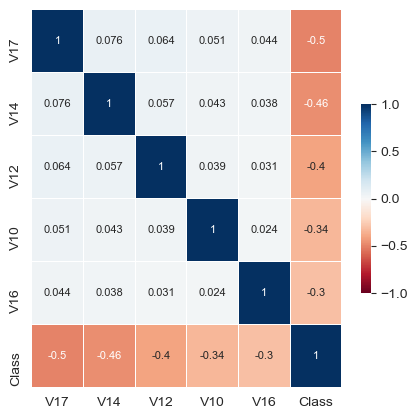

In [46]:
## Visualizing correlation of Top5 feature variables with 'Class' 
top5_features= list(corr_matrix_top10_class_only.index)[0:5]
top5_features.append('Class')
corr_matrix_top= corr_matrix[top5_features].corr()
plt.figure(figsize=(5,5),dpi=100)
sns.heatmap(corr_matrix_top, cmap= "RdBu", annot= True,cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,\
             linewidths=0.01, annot_kws={"size":8})
plt.show()

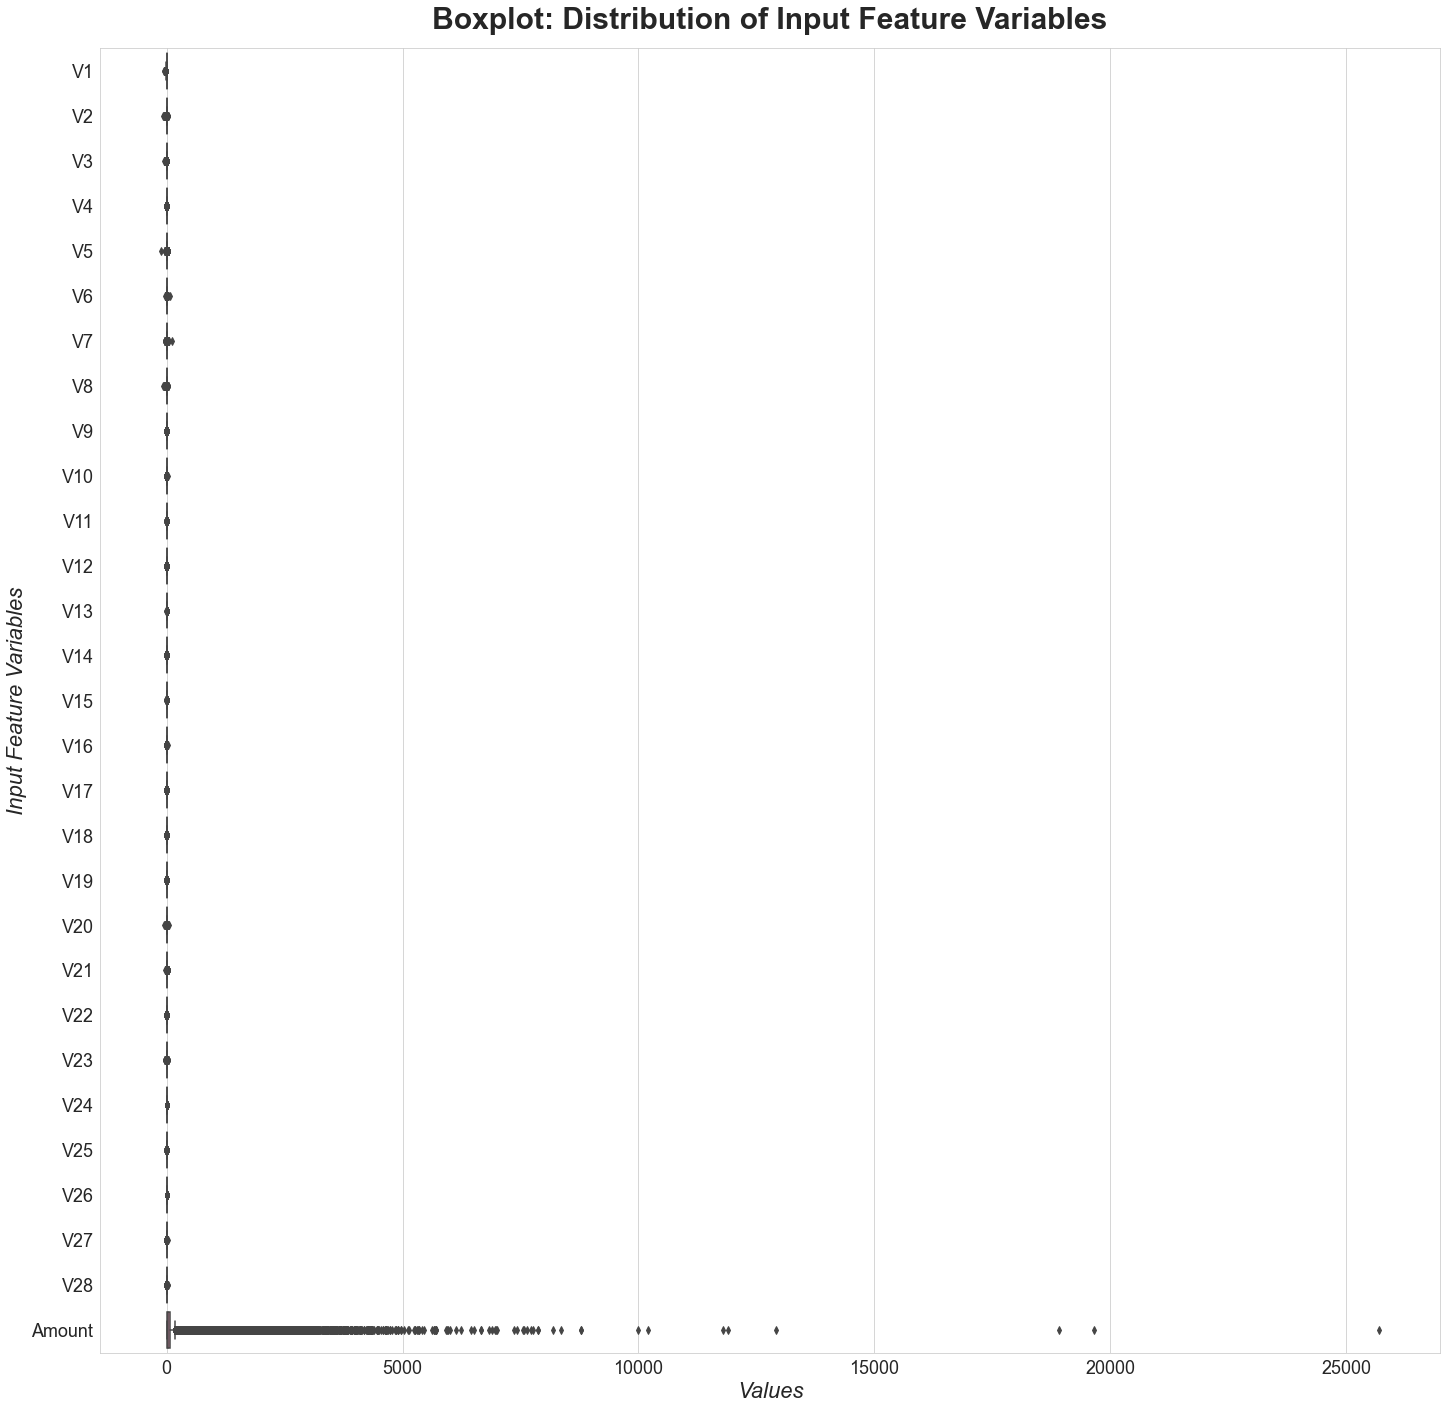

In [47]:
# Boxplot to understand the distribution of numerical attributes :
numeric_feature_variables= df.select_dtypes(include=['float64','int64', 'int32'])

## Exluding dependent variables "Class" from the list
numeric_feature_variables= [i for i in numeric_feature_variables if i!="Class"]

plt.figure(figsize=(24,24))
sns.boxplot(data= df[numeric_feature_variables], orient= "h")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Boxplot: Distribution of Input Feature Variables", y=1.01, fontsize=30, fontweight='bold')
plt.ylabel("Input Feature Variables", fontstyle='italic', fontsize=22)
plt.xlabel("Values", fontstyle='italic', fontsize=22)
plt.show()

In [48]:
## Create X and y dataset for independent and dependent data
y= df['Class']        #Class variable
X= df.drop("Class", axis=1)

In [49]:
## Splitting the data into train and test data  (80:20)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.20, stratify= y)

In [50]:
# Note: The stratified train-test split ratio wasn't mentioned in the starter code. 
# Considering train_test_split ratio (80:20)

print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


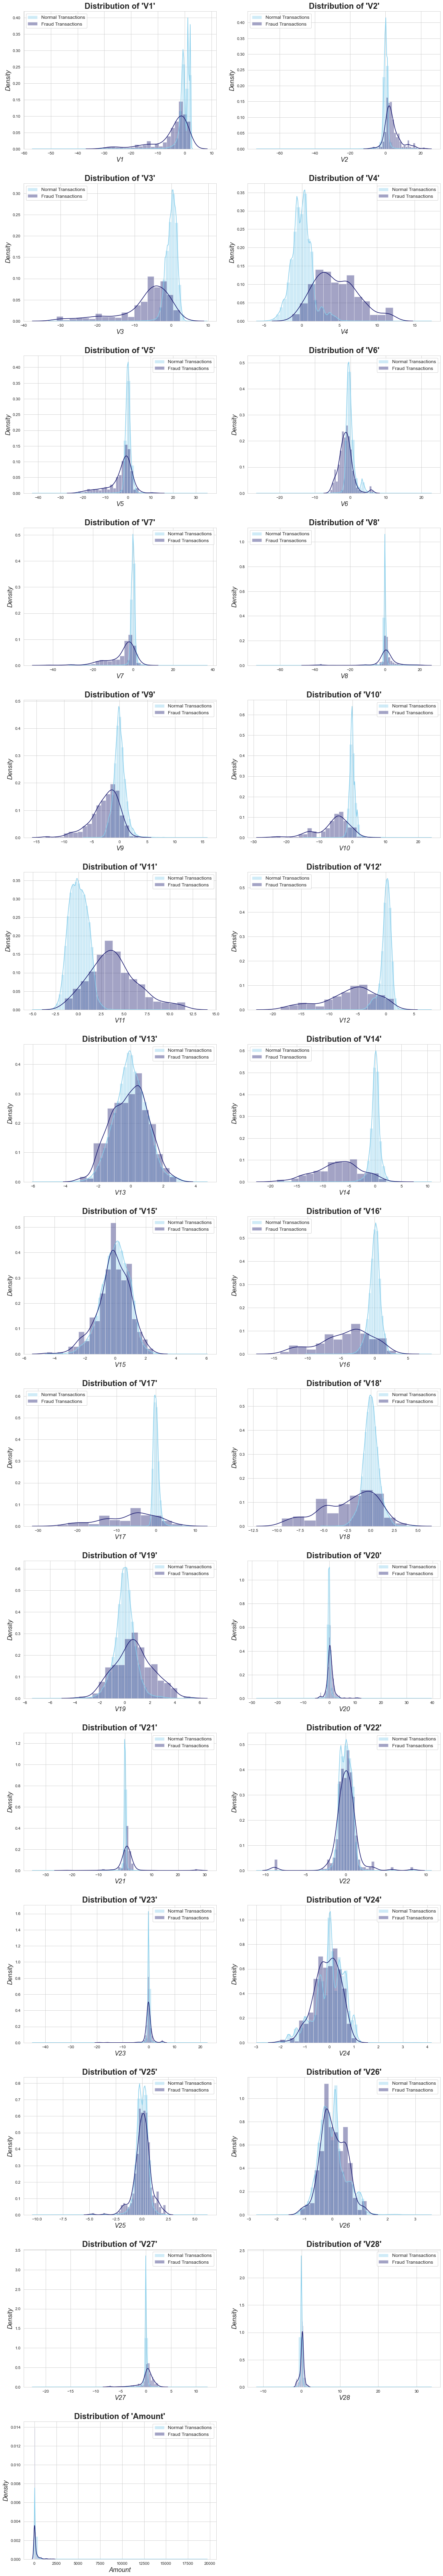

In [51]:
# Plotting histograms to check the distribution of variables (in train data) for skewness

# Define a function for the plot
def plot_histograms_distribution_of_variables(check_data):
    input_feature_list= list(X.columns)       # list of input feature variables (analyzing entire dataset)

    f1, ax_skew1 = plt.subplots(15,2, figsize=(16,90))
    f1.delaxes(ax_skew1[14,1])    ## Passing indices of axes--This line will delete the last axis (used for odd-subplots)

    for index, feature in enumerate(input_feature_list):
        plt.subplot(15,2,index+1)
        sns.distplot(check_data[feature][df.Class == 0], label= "Normal Transactions", color='skyblue')       ## Distplot for feature density in Normal Transactions
        sns.distplot(check_data[feature][df.Class == 1], label= "Fraud Transactions", color= 'midnightblue')  ## Distplot for feature density in Fraud Transactions
        plt.title(f"Distribution of '{feature}'", fontsize= 20, fontweight='bold') 
        plt.xlabel(feature, fontsize=16, fontstyle= 'italic')
        plt.ylabel("Density", fontsize=16, fontstyle= 'italic')
        plt.tight_layout(pad=3.0)   ##Increase spacing between subplots
        plt.legend(fontsize= 12)
    plt.show()

# Plotting histograms to check the distribution of variables (in train dataset) for skewness
plot_histograms_distribution_of_variables(X_train)

In [52]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train data & transform the test data

## For X dataset (train and test) 
pt = PowerTransformer(copy=False)                  ## Instantiate an object of PowerTransformer() class 
X_train_pt= pt.fit_transform(X_train)              ## fit_transform train set
X_test_pt = pt.transform(X_test)                   ## Transform only: test set

In [53]:
## Create a dataframes for PowerTransformed 'X_train' and 'X_test' respectively (to be used later)
X_train_pt_df= pd.DataFrame(data= X_train_pt, columns= list(X.columns))
X_test_pt_df= pd.DataFrame(data= X_test_pt, columns= list(X.columns))

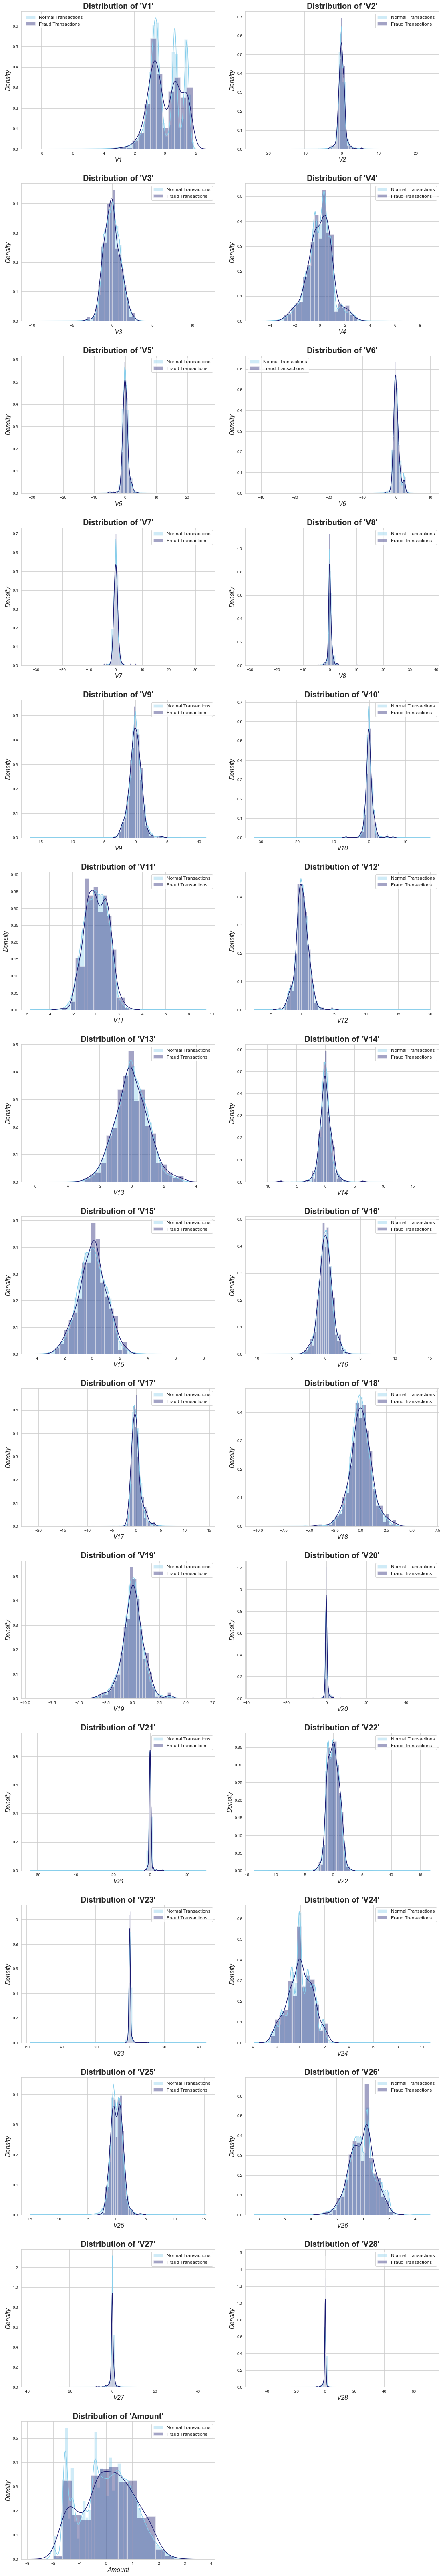

In [54]:
# Plotting histograms to check the distribution of variables (in power transformed 'X_train_pt_df' set) for skewness
plot_histograms_distribution_of_variables(X_train_pt_df)

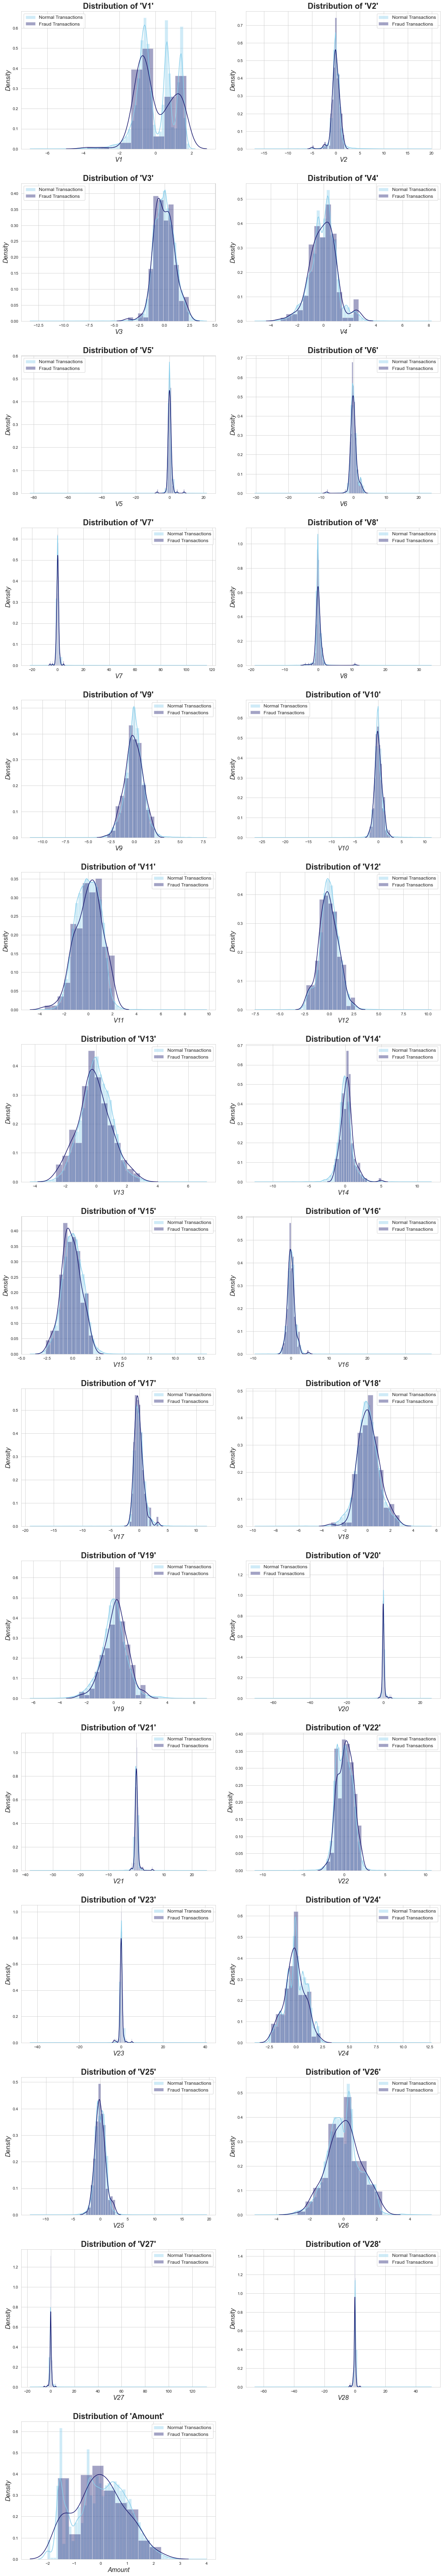

In [55]:
# Plotting histograms to check the distribution of variables (in power transformed 'X_test_pt_df' set) for skewness
plot_histograms_distribution_of_variables(X_test_pt_df)

In [62]:
ros = over_sampling.RandomOverSampler(random_state=0)                  # Creating a class instance of RandomOverSampler()         
X_train_ros, y_train_ros = ros.fit_resample(X_train_pt, y_train)   

NameError: name 'over_sampling' is not defined

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logClassifier=LogisticRegression(random_state=1) # Create the model
log_output = logClassifier.fit(X_train_ros,y_train_ros) # fitting the model

In [ ]:
THRESHOLD = 0.5
y_pred_dthreshold50 = np.where(logClassifier.predict_proba(X_test_pt_df)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame({"predicted":y_pred_dthreshold50,"actual":y_test})

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()

In [ ]:
clf.fit(X_train_ros,y_train_ros)

In [ ]:
dec_pred=clf.predict(X_test_pt_df)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,dec_pred)

In [51]:
cm = confusion_matrix(y_test, dec_pred)
print(cm)

[[56836    28]
 [   27    71]]


In [53]:
TP = cm[1, 1] # True Positives
TN = cm[0, 0] # True Negatives
FP = cm[0, 1] # False Positives
FN = cm[1, 0] # False Negatives

In [55]:
precision = TP / (TP + FP)
print(f"{precision:.4f}")

0.7172


In [57]:
recall = TP / (TP + FN)
print(f"{recall:.4f}")

0.7245


In [59]:
f1_Score = (2 * precision * recall) / (precision + recall)
print(f"{f1_Score:.4f}")

0.7208


In [61]:
print(accuracy_score(y_test, dec_pred))

0.9990344440153085


In [62]:
# Hyper Parameter Tuning

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
score_measure = 'precision'
k_fold = 10
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [2, 5, 10, 20, 30, 40], 
    'min_samples_split': [2, 5, 10, 20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=k_fold, scoring=score_measure,
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs 
gridSearch.fit(X_train_ros, y_train_ros)
print(score_measure, 'score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestPrecisionTree = gridSearch.best_estimator_

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(X_train_ros, y_train_ros)
print(score_measure, 'score: ', gbc.best_score_)
#print(classification_report(y_val, gbc.predict(x_val), target_names=['Not Fraud', 'Fraud']))

NameError: name 'X_train_ros' is not defined

In [ ]:
def neural_net_predictions(model, x):
  return (model.predict(x).flatten() > 0.5).astype(int)
neural_net_predictions(shallow_nn, x_val)
print(classification_report(y_val, neural_net_predictions(shallow_nn, x_val), target_names=['Not Fraud', 'Fraud']))